In [ ]:
# Mount notebook to google drive: 

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
!pip install pytorch-lightning
!pip install trimesh

In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torch.nn import functional as F
from torchmetrics import Accuracy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import preprocessing
from enum import Enum 
from torch import Tensor
import torch_sparse
import matplotlib.pyplot as plt
import trimesh
import time
import os
import random
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from bokeh.palettes import Magma10
import os
import trimesh
from pytorch_lightning import LightningModule, Trainer
from torch import nn
import torch_geometric
from sklearn.preprocessing import StandardScaler

In [ ]:
# Create mesh dataset:

mesh_path = './gdrive/Shared drives/JG0AAF901 Kyklos 4.0/Working/ML_dataset/rand_boxes_dataset_2_50000' 

mesh_dataset = []
for filename in os.listdir(mesh_path):

  if filename.endswith('.stl'):
    mesh = trimesh.load(f'{mesh_path}/{filename}')
    mesh_dataset.append(mesh)

  if len(mesh_dataset) == 15000:
    break

print(len(mesh_dataset))

In [ ]:
# Show an exmaple:

mesh_dataset[4230].show()

In [ ]:
# Calculate volumes and normalize them:
# Create final mesh dataset:


volumes = []
for mesh in mesh_dataset:
  vol = mesh.volume
  volumes.append(vol)

print(np.max(volumes))
print(np.min(volumes))

thres1 = np.max(volumes) #/ 1.5
thres2 = np.min(volumes) #* 10000
print("thres1: ", thres1)
print("thres2: ", thres2)
mesh_ds = []
vols = []
for i in range(len(volumes)):

  if volumes[i] <= thres1 and volumes[i] >= thres2:
    vols.append(volumes[i])
    mesh_ds.append(mesh_dataset[i])


norm_volumes = []
for v in vols:

  norm_v = v / np.max(vols)
  norm_volumes.append(norm_v)
    

# Check min-max of normalized data (must be in (0,1))
print(np.max(norm_volumes))
print(np.min(norm_volumes))

In [ ]:
# Show new dataset's size:

print(len(mesh_ds))

In [ ]:
# Calculate vertices MIN/ MAX value:

vertices = []
max_verts = []
min_verts = []
for mesh in mesh_ds:
  verts = mesh.vertices
  vertices.append(verts)
  max_verts.append(np.max(verts))
  min_verts.append(np.min(verts))

MAX = np.max(max_verts)
MIN = np.min(min_verts)
print(MAX)
print(MIN)

In [ ]:
# Normalize vertices:

norm_vertices = []
max_norm_vert = []
for v in vertices:
  norm_v = (v - MIN) / (MAX - MIN) 
  norm_vertices.append(norm_v)
  max_norm_vert.append(np.max(norm_v))


# Check min-max of normalized data (must be in (0,1))
print(np.max(max_norm_vert))
print(np.min(max_norm_vert))


In [ ]:
# Custom Dataset Class
## Needs ATLEAST 3 class methods
## __init__, __len__, __getitem__

class CustomDataset(Dataset):
    
    import torch_geometric.data
    from torch_geometric.data import Data
    


    # This loads the data and converts it, make data rdy
    def __init__(self, dataset, volumes):
        
        self.x_list = []
        self.edge_index_list = []
        self.y_list = []


        for mesh in dataset:
          # node_attributes:
          x = torch.from_numpy(np.array(((mesh.vertices - MIN) / (MAX - MIN)))).to(torch.float)  
          self.x_list.append(x)
          # edge_index:
          edge_index = torch.from_numpy(mesh.edges).to(torch.long).t().contiguous()
          self.edge_index_list.append(edge_index)
         

        for vol in volumes:  
          # volume:
          y=torch.from_numpy(np.array(vol)).float()
          self.y_list.append(y)

        # Create Data
        self.data_list = []
        for i in range(len(self.y_list)):
          data = Data(x=self.x_list[i], edge_index=self.edge_index_list[i], y=self.y_list[i])
          self.data_list.append(data)

        # Create dataset:
        self.graph_ds = torch_geometric.data.Batch.from_data_list(self.data_list)
        self.num_node_features = len(self.x_list[0][0])
  
             
    
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.graph_ds)
    
    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        return self.graph_ds[idx]

In [ ]:
# Create our dataset:

dataset=CustomDataset(dataset=mesh_ds, volumes=norm_volumes)

print(len(dataset))

In [ ]:
# Print some information about the dataset

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')



data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

In [ ]:
# Split dataset for training , validation and testing

train_dataset = dataset[:13000]
val_dataset = dataset[13000:14500]
test_dataset = dataset[14500:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 13000
Number of validation graphs: 1500
Number of test graphs: 500


In [ ]:
# Create DataLoaders:

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

In [ ]:
# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import pytorch_lightning as pl

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 50
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/GNNs/")

# Setting the seed
pl.seed_everything(42)

In [ ]:
# Import GNN layers by name:

gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

In [ ]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """
        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(layer, geom_nn.MessagePassing):
                x = layer(x, edge_index)
            else:
                x = layer(x)
        return x

In [ ]:
class GraphGNNModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of output features (usually number of classes)
            dp_rate_linear: Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs: Additional arguments for the GNNModel object
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in, c_hidden=c_hidden, c_out=c_hidden, **kwargs)  # Not our prediction output yet!
        self.head = nn.Sequential(nn.Dropout(dp_rate_linear), nn.Linear(c_hidden, c_out))

    def forward(self, x, edge_index, batch_idx):
        """
        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx: Index of batch element for each node
        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx)  # Average pooling
        x = self.head(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
class GraphLevelGNN(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        
        self.model = GraphGNNModel(**model_kwargs)

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1) 
        return x
  
  
    def training_step(self, data):

        x_out = self.forward(data)
        loss = nn.MSELoss(x_out, data.y)

        # metrics here:
        self.log("loss/train", loss)

        return loss


    def validation_step(self, data, batch_idx):


        x_out = self.forward(data)

        loss = nn.MSELoss(x_out, data.y)

        # metrics here:
        self.log("loss/validation", loss)

        return loss


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 3e-4, weight_decay=0.0)

In [ ]:
def evaluate(model, test_loader, save_results=True, tag="_default", verbose=False):

    # get test accuracy score:

    my_device = "cuda" if torch.cuda.is_available() else "cpu"
    criterion = torch.nn.MSELoss()

    model.eval()
    total_loss = 0
    total_batches = 0

    for batch in test_loader:

        pred = model(batch.to(my_device))

        loss = criterion(pred, batch.y.to(my_device))

        total_loss += loss.detach()
        total_batches += batch.batch.max()

    test_loss = total_loss / total_batches

    results = {
        "loss": test_loss, \
        "tag": tag }

    return results

In [ ]:
from torch.utils.tensorboard import SummaryWriter

T_loss = []
V_loss = []

def train_model(model, train_loader, criterion, optimizer, num_epochs=1000, \
        verbose=True, val_loader=None, save_tag="default_run_"):


    ## call validation function and print progress at each epoch end
    display_every = 1 #num_epochs // 10
    my_device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(my_device)

    # we'll log progress to tensorboard
    log_dir = f"lightning_logs/plain_model_{str(int(time.time()))[-8:]}/"
    writer = SummaryWriter(log_dir=log_dir)

    t0 = time.time()
    for epoch in range(num_epochs):

        total_loss = 0.0
        batch_count = 0
        for batch in train_loader:
            optimizer.zero_grad()

            pred = model(batch.to(my_device))
            loss = criterion(pred, batch.y.to(my_device))
            loss.backward()

            optimizer.step()

            total_loss += loss.detach()
            batch_count += 1

        mean_loss = total_loss / batch_count
        

        writer.add_scalar("loss/train", mean_loss, epoch)

        if epoch % display_every == 0:
            train_results = evaluate(model, train_loader, \
            tag=f"train_ckpt_{epoch}_", verbose=True)
            train_loss = train_results["loss"]
            
      

        if val_loader is not None:
            val_results = evaluate(model, val_loader, \
            tag=f"val_ckpt_{epoch}_", verbose=True)
            val_loss = val_results["loss"]
          
            
            
        T_loss.append(train_loss)
        V_loss.append(val_loss)

        
        print(f"Epoch: {epoch},  Train loss: {train_loss},  Val_loss: {val_loss}")


In [ ]:

model = GraphLevelGNN(c_in=3, c_hidden=64, c_out=1)
lr = 1e-3
num_epochs = 100

criterion = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_model(model, train_loader, criterion, optimizer,\
          num_epochs=num_epochs, verbose=True, \
          val_loader=val_loader)

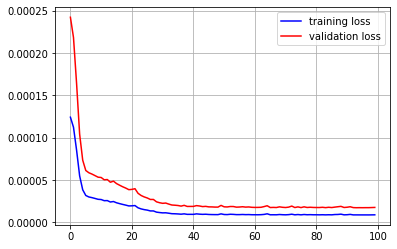

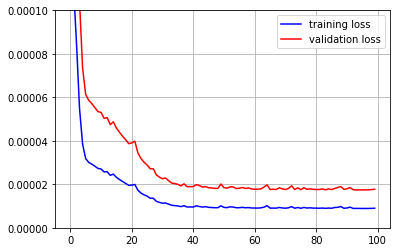

In [ ]:
# Plot training and validation losses:

import matplotlib.pyplot as plt
from torch import tensor

plt.figure(1)
plt.plot(tensor(T_loss).detach().numpy(), color='b', label='training loss')
plt.plot(tensor(V_loss).cpu(), color='r', label='validation loss')
plt.legend(loc='upper right')
plt.grid()
#plt.show()

plt.figure(2)
plt.plot(tensor(T_loss).detach().numpy(), color='b', label='training loss')
plt.plot(tensor(V_loss).cpu(), color='r', label='validation loss')
plt.ylim(0, 10**(-4))
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
# Test the model:

my_device = "cuda" if torch.cuda.is_available() else "cpu"

Real = []
Predictions = []
Error = []

for i in range(len(test_dataset)):
  
  test = test_dataset[i]
  y_test = test.y

 
 
  
  Real.append(y_test)
  #print(y_test)
  
  
  preds = model(test.to(my_device))
  Predictions.append(preds)
  #print(preds)
  
for i in range(len(Predictions)):
  rv = Real[i][0]
  pv = Predictions[i][0] 
  # Σχετικό Σφάλμα:
  err = np.abs((tensor(rv).cpu() - tensor(pv).cpu()) / tensor(rv).cpu())
  Error.append(err)
  print(f"test mesh {i}: Real volume: {rv}   vs   Predicted volume: {pv}   vs  error: {err}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test mesh 0: Real volume: 0.32042643427848816   vs   Predicted volume: 0.32317236065864563   vs  error: 0.008569600060582161
test mesh 1: Real volume: 0.7167100310325623   vs   Predicted volume: 0.6650996804237366   vs  error: 0.0720100849866867
test mesh 2: Real volume: 0.1858508586883545   vs   Predicted volume: 0.222849503159523   vs  error: 0.1990770697593689
test mesh 3: Real volume: 0.2834259867668152   vs   Predicted volume: 0.3105965256690979   vs  error: 0.0958646684885025
test mesh 4: Real volume: 0.2966980040073395   vs   Predicted volume: 0.19230298697948456   vs  error: 0.35185614228248596
test mesh 5: Real volume: 0.2694776952266693   vs   Predicted volume: 0.331649512052536   vs  error: 0.23071229457855225
test mesh 6: Real volume: 0.41777387261390686   vs   Predicted volume: 0.3948974609375   vs  error: 0.05475788190960884
test mesh 7: Real volume: 0.1797322928905487   vs   Predicted volume: 0.23482191562652588   vs  error: 0.3065093159675598
test mesh 8: Real volume: 0

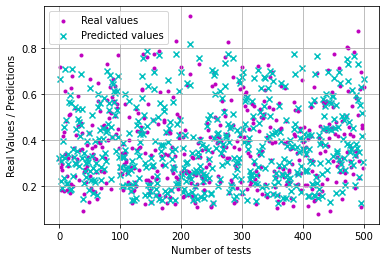

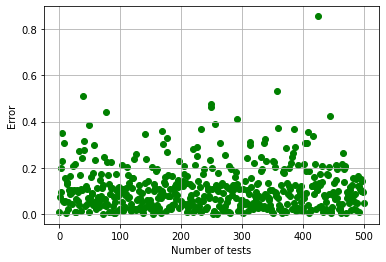

In [ ]:
# Plot real values vs predictions:

N = len(Real)
x = np.linspace(0, N, N)

plt.figure(3)
plt.scatter(x, tensor(Real).cpu(), color='m', marker='.', label='Real values')
plt.scatter(x, tensor(Predictions).detach().numpy(), color='c', marker='x', label='Predicted values')
plt.legend()
plt.xlabel("Number of tests")
plt.ylabel("Real Values / Predictions")
plt.grid()
#plt.show()

plt.figure(4)
plt.scatter(x, Error, color='g')
plt.xlabel("Number of tests")
plt.ylabel("Error")
plt.grid()
plt.show()